In [31]:
import pandas as pd
df = pd.read_csv('/Users/nickhausman/Desktop/DATA/DATA_403_Project_2/cleaned_training_data.csv')
bb = pd.read_csv('/Users/nickhausman/Desktop/DATA/P2/home-credit-default-risk/bureau_balance.csv')
b = pd.read_csv('/Users/nickhausman/Desktop/DATA/P2/home-credit-default-risk/bureau.csv')
df.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT,HOUSING_SCORE
0,0,100002,1,Cash loans,M,N,Y,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,1,0.0
1,8,100016,0,Cash loans,F,N,Y,67500.0,80865.0,5881.5,...,0,0,0,0,0,0,0,0,1,2.0
2,9,100017,0,Cash loans,M,Y,N,225000.0,918468.0,28966.5,...,0,0,0,0,0,0,0,0,1,7.0
3,12,100022,0,Revolving loans,F,N,Y,112500.0,157500.0,7875.0,...,0,0,0,0,0,0,0,0,0,2.0
4,15,100026,0,Cash loans,F,N,N,450000.0,497520.0,32521.5,...,0,0,0,0,0,0,0,0,1,3.0


In [32]:
bb = bb.drop('MONTHS_BALANCE', axis=1)

I dropped months_balance, because it seems mostly useless as were are only looking to penalize late payments, and not consider on time ones. 

In [33]:
b = b[['SK_ID_CURR', 'SK_ID_BUREAU', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM']]

After redeaing through the bureau.csv descriptions, only this subset seems useful for our calculations.

In [34]:
bb.head()

,SK_ID_BUREAU,STATUS
0,5715448,C
1,5715448,C
2,5715448,C
3,5715448,C
4,5715448,C


In [35]:
bb = bb[(bb.STATUS != 'X') & (bb.STATUS != 'C') & (bb.STATUS != '0')] # Only want to see bad examples, not goood ones
bb.STATUS = bb.STATUS.astype(int)
bb.STATUS.value_counts()

1    242347
5     62406
2     23419
3      8924
4      5847
Name: STATUS, dtype: int64

In [36]:
b.head()

,SK_ID_CURR,SK_ID_BUREAU,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM
0,215354,5714462,0.0,NaN,0,91323.0
1,215354,5714463,0.0,NaN,0,225000.0
2,215354,5714464,0.0,NaN,0,464323.5
3,215354,5714465,0.0,NaN,0,90000.0
4,215354,5714466,0.0,77674.5,0,2700000.0


In [37]:
comb = pd.merge(b, bb, on='SK_ID_BUREAU', how='left').fillna(0).groupby(['SK_ID_CURR']).sum().drop('SK_ID_BUREAU', axis=1)
comb.head()

,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,STATUS
SK_ID_CURR,,,,,
100001,0.0,0.00,0,1453365.000,1.0
100002,0.0,30053.79,0,4343645.565,27.0
100003,0.0,0.00,0,1017400.500,0.0
100004,0.0,0.00,0,189037.800,0.0
100005,0.0,0.00,0,657126.000,0.0


Going to replace NA values with 0, seems resonable because other columns are usually 0. Did outer join so we don't eliminate those without a status

In [38]:
comb.describe()

,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,STATUS
count,3.058110e+05,3.058110e+05,305811.000000,3.058110e+05,305811.000000
mean,3.730718e+02,3.537653e+04,8.108230,2.306222e+06,1.854198
std,4.282109e+04,9.977463e+06,517.448922,6.843557e+06,17.149877
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,3.600000e+05,0.000000
50%,0.000000e+00,0.000000e+00,0.000000,1.028097e+06,0.000000
75%,0.000000e+00,2.160000e+02,0.000000,2.511464e+06,0.000000
max,1.598967e+07,5.499110e+09,176880.000000,1.204461e+09,1746.000000


Creating a score- how to do it? 

In [39]:
poss_score = comb.sum(axis=1)
poss_score.describe()

count    3.058110e+05
mean     2.341981e+06
std      1.385053e+07
min      0.000000e+00
25%      3.615070e+05
50%      1.032766e+06
75%      2.520776e+06
max      6.703572e+09
dtype: float64

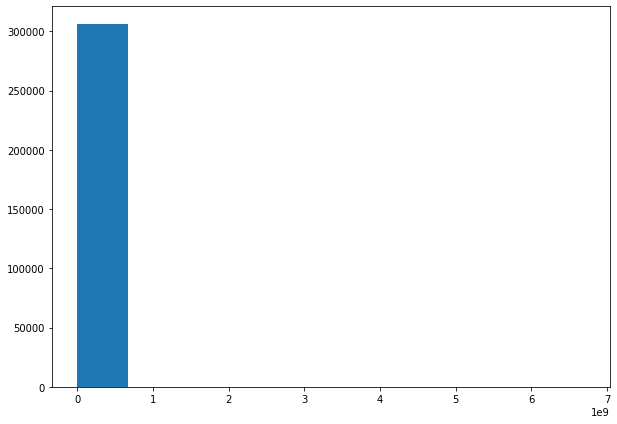

In [40]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(poss_score)
plt.show()

Clearly doesn't work, lets try using logistic regression to create a probability score

In [41]:
for_lr = pd.merge(df[['SK_ID_CURR', 'TARGET']], comb, on='SK_ID_CURR').drop('SK_ID_CURR', axis=1)
for_lr

,TARGET,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,STATUS
0,1,0.0,30053.790,0,4343645.565,27.0
1,0,0.0,0.000,0,474984.000,0.0
2,0,0.0,0.000,0,859770.000,0.0
3,0,0.0,0.000,0,1057500.000,0.0
4,0,0.0,0.000,0,5625000.000,0.0
...,...,...,...,...,...,...
126931,0,0.0,101371.410,0,8769015.495,12.0
126932,0,0.0,30735.000,0,3693858.660,0.0
126933,0,0.0,0.000,0,3960000.000,0.0
126934,1,0.0,0.000,0,45000.000,0.0


In [54]:
for_lr.describe()

,TARGET,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,STATUS
count,126936.000000,1.269360e+05,1.269360e+05,126936.000000,1.269360e+05,126936.000000
mean,0.067948,3.615034e+02,5.660188e+04,7.775257,2.555370e+06,1.656488
std,0.251657,3.838987e+04,1.543902e+07,523.416346,7.927535e+06,17.378048
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,4.472246e+05,0.000000
50%,0.000000,0.000000e+00,0.000000e+00,0.000000,1.191757e+06,0.000000
75%,0.000000,0.000000e+00,1.440000e+03,0.000000,2.858895e+06,0.000000
max,1.000000,1.203329e+07,5.499110e+09,175560.000000,1.204461e+09,1746.000000


In [55]:
for_lr[for_lr['TARGET']==1].describe()

,TARGET,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_MAX_OVERDUE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,STATUS
count,8625.0,8.625000e+03,8.625000e+03,8625.000000,8.625000e+03,8625.000000
mean,1.0,9.858386e+02,2.575314e+04,10.228522,2.334865e+06,2.178319
std,0.0,2.851186e+04,8.180990e+05,161.017241,4.335676e+06,18.609127
min,1.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,1.0,0.000000e+00,0.000000e+00,0.000000,3.947900e+05,0.000000
50%,1.0,0.000000e+00,0.000000e+00,0.000000,1.156569e+06,0.000000
75%,1.0,0.000000e+00,5.949945e+03,0.000000,2.736328e+06,0.000000
max,1.0,2.387232e+06,7.310430e+07,8239.000000,2.111738e+08,738.000000


In [42]:
def pad_B0(X, ret_numpy=True):
    X['B0'] = 1
    X = X[['B0'] + list(X.drop(columns='B0').columns)]
    if ret_numpy:
        return X.to_numpy() 
    return X

In [43]:
from Models import Logistic, Model
 
lr = Model('Logistic')
Y = for_lr['TARGET']
X = for_lr.drop('TARGET', axis=1)
B = lr.fit(pad_B0(X), Y.to_numpy(), etas=[1e-16])
probs = lr.predict(X.to_numpy(), B, True, .5)

Eta: 1e-16; Iterations: 75000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD


/Users/nickhausman/Desktop/DATA/DATA_403_Project_2/Models.py:94: RuntimeWarning: underflow encountered in exp
  probabilities = 1 / (1 + np.exp(-1 * X @ B))


In [44]:
lr.coef_

array([-1.48925665e-07,  1.33558656e-06,  1.15932940e-07, -5.49159606e-07,
       -1.60199700e-06,  5.64214871e-08])

In [45]:
probs = pd.Series(probs)
probs.describe()

count     1.269360e+05
mean      3.009798e-01
std       1.584633e-01
min      1.659986e-243
25%       1.741052e-01
50%       3.437677e-01
75%       4.403583e-01
max       1.000000e+00
dtype: float64